In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import random

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

dualanimals = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']

In [2]:
act_directory = "/Users/InsanallyLab/Desktop/Analysis_Cache"

In [3]:
animals_in_cache = []
EnumSession = []
EnumClust = []
EnumOnlySession = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
    
    if sessionfile.meta.animal not in dualanimals:
        continue
        
    if not sessionfile.meta.region == 'AC':
        continue
        
    EnumOnlySession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 488/488 [00:36<00:00, 13.32it/s]


In [4]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [5]:
#Get learning phase definition

In [6]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     if sessionfile.meta.region != 'AC':
#         continue
#     training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 488/488 [00:38<00:00, 12.81it/s]

[]


In [7]:
dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
# opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
BS_78
BS_78 has no post-reversal
inf


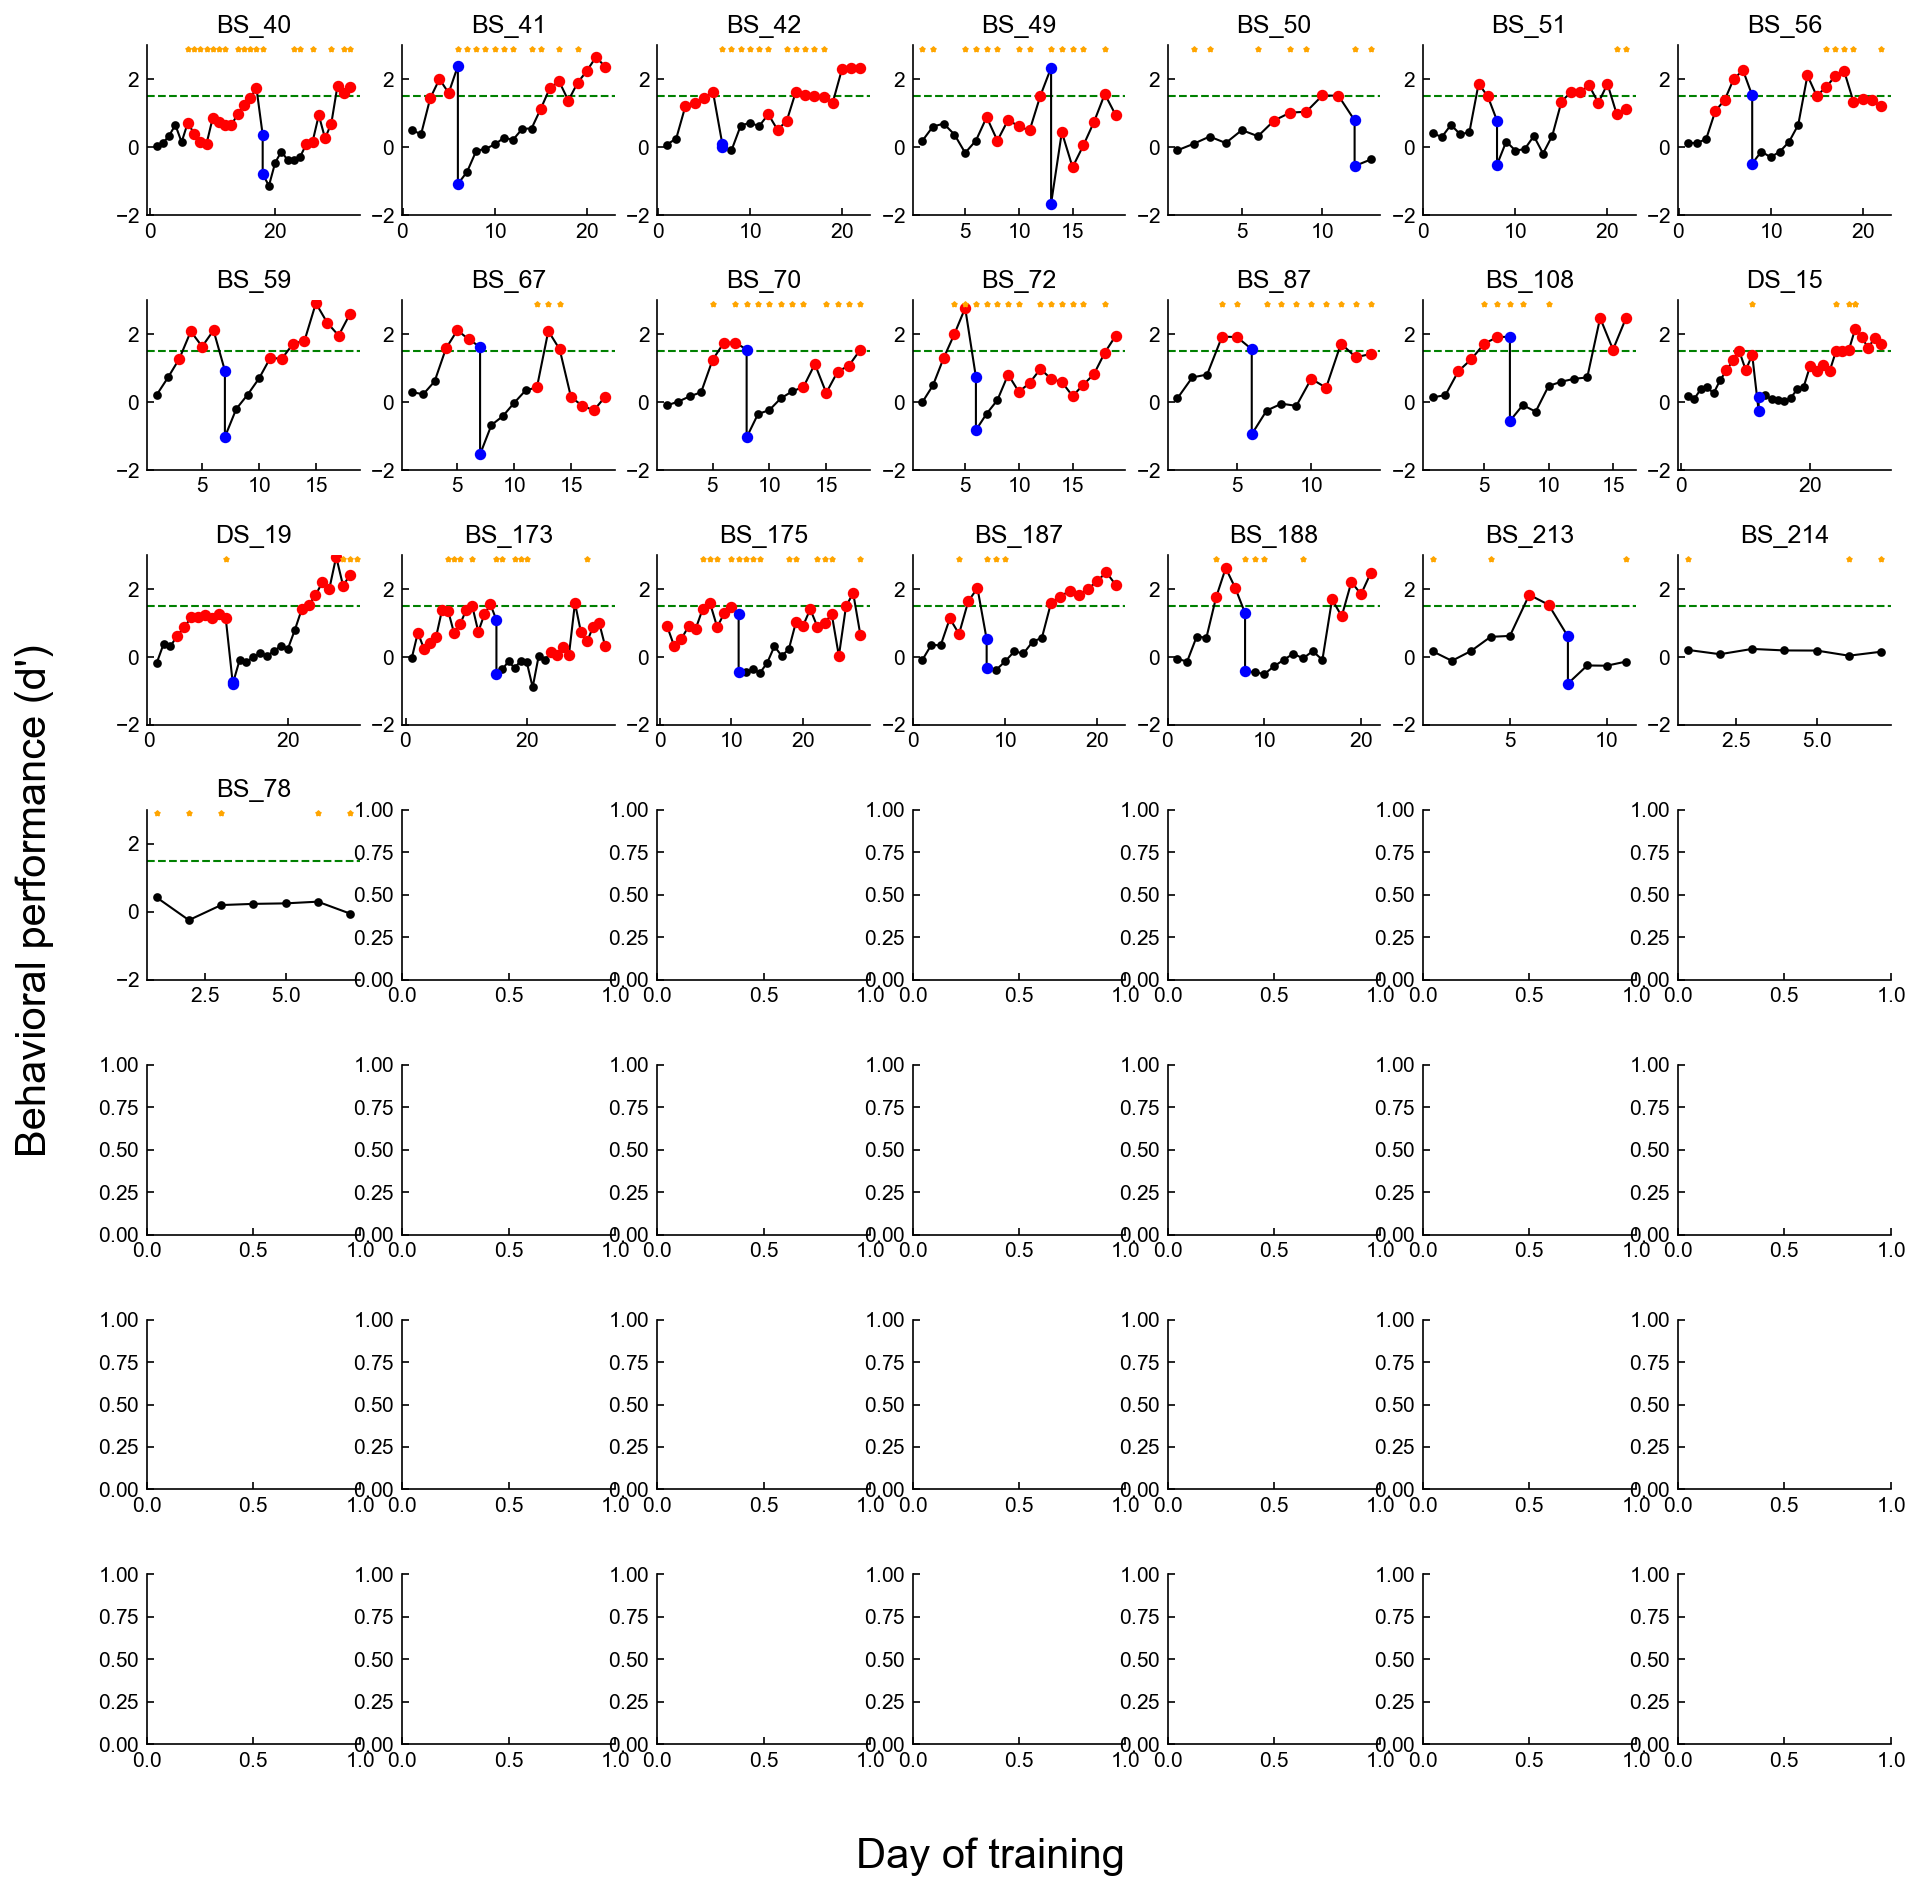

In [8]:
filename = os.path.join('/Users/InsanallyLab/Desktop/DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [9]:
EILphases = np.full_like(EnumOnlySession,np.nan)

for idx,session in enumerate(tqdm(EnumOnlySession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.condition=='prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.condition=='prereversal expert':
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.condition=='postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.condition=='postreversal expert':
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        #print(e)
        pass

100%|██████████| 142/142 [00:07<00:00, 19.14it/s]


In [10]:
print(np.unique(EILphases))

['nan' 'post early' 'post expert' 'post late' 'pre early' 'pre expert'
 'pre late' 'switch']


In [11]:
#each index is for each cell/cluster
#so length of EnumSession = EnumClust = EILphases

In [12]:
#Create learning phase array with sessions'index
pre_early = []
pre_late = []
pre_expert = []
post_early = []
post_late = []
post_expert = []

for idx,phase in enumerate(EILphases):
    if phase == 'pre early':
        pre_early.append(idx)
    if phase == 'pre late':
        pre_late.append(idx)
    if phase == 'pre expert':
        pre_expert.append(idx)
    if phase == 'post early':
        post_early.append(idx)
    if phase == 'post late':
        post_late.append(idx)
    if phase == 'post expert':
        post_expert.append(idx)

#create session file array for each learning phase
pre_early_session = []
pre_late_session = []
pre_expert_session = []
post_early_session = []
post_late_session = []
post_expert_session = []

for idx, session_idx in enumerate(pre_early):
    pre_early_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(pre_late):
    pre_late_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(pre_expert):
    pre_expert_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_early):
    post_early_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_late):
    post_late_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_expert):
    post_expert_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))


In [13]:
#Sessions for each learning phase
pre_early = pre_early_session
pre_late= pre_late_session
pre_expert= pre_expert_session

post_early = post_early_session
post_late= post_late_session
post_expert= post_expert_session



In [14]:
print(len(pre_early))
print(len(pre_late))
print(len(pre_expert))
print(len(post_early))
print(len(post_late))
print(len(post_expert))

7
16
10
25
19
23


In [15]:
raise NotImplementedError("file already exist")
#####Calculate pval for each learning phase

def calculate_NCR_CR_pval_phase(phase):
    pvals = []
    for sessionfile in phase:
        for clust in sessionfile.clusters.good:
            pvals.append(calculate_NCR_CR_pval(sessionfile,clust))
    return pvals

#Calculate 
pval_preearly = calculate_NCR_CR_pval_phase(pre_early)
pval_prelate = calculate_NCR_CR_pval_phase(pre_late)
pval_preexpert = calculate_NCR_CR_pval_phase(pre_expert)

pval_postearly = calculate_NCR_CR_pval_phase(post_early)
pval_postlate = calculate_NCR_CR_pval_phase(post_late)
pval_postexpert = calculate_NCR_CR_pval_phase(post_expert)

#Create pvalue pickle file
Pval = SimpleNamespace(prereversal_early=pval_preearly,
                      prereversal_late=pval_prelate,
                      prereversal_expert=pval_preexpert,
                      postreversal_early=pval_postearly,
                      postreversal_late=pval_postlate,
                      postreversal_expert=pval_postexpert
                     )

#Save p_values to Pval.pickle
filename = '/Users/insanallylab/Desktop/NCR_CR_Classification/NCR_CR_Pval.pickle'
with open(filename, 'wb') as f:
    pickle.dump(Pval, f, protocol=pickle.HIGHEST_PROTOCOL)


NotImplementedError: file already exist

In [16]:
#Load p_values from Pval.pickle
with open("/Users/insanallylab/Desktop/NCR_CR_Classification/NCR_CR_Pval.pickle", "rb") as f:
    cell_pval = pickle.load(f)  

In [126]:
cell_pval.prereversal_early[:10]

[(0.0, 0.83, 0.17),
 (0.954, 0.0, 0.046),
 (0.9998, 0.0, 0.0002),
 (1.0, 0.0, 0.0),
 (0.0058, 0.0, 0.9942),
 (0.5906, 0.0, 0.4094),
 (0.0, 0.0002, 0.9998),
 (0.3606, 0.0, 0.6394),
 (1.0, 0.0, 0.0),
 (1.0, 0.0, 0.0)]

In [127]:
len(cell_pval.prereversal_early[:10])

10

In [18]:
#Get learning phase pvals
preearly_pval = cell_pval.prereversal_early
prelate_pval = cell_pval.prereversal_late
preexpert_pval = cell_pval.prereversal_expert

postearly_pval = cell_pval.postreversal_early
postlate_pval = cell_pval.postreversal_late
postexpert_pval = cell_pval.postreversal_expert

In [19]:
#For each learning phase:

In [130]:
#version1
#1. gives the classification array of one cluster, ie, preearly_pval[0]
thresh = 0.05 #5%

def calculate_CR_NCR_ver1(p_values):
    
    #get p values from pval.pickle
    p_value_evoked = p_values[0]
    p_value_suppressed = p_values[1]
    p_value_NCR = p_values[2]
    
    #print(p_value_evoked,p_value_suppressed, p_value_NCR)
    
    #calculate true and false
    CR_evok=False
    CR_sup=False
    NCR=False
    Inconclusive=False
    
    #NCR >=95%
    if p_value_NCR >=1-thresh:
        NCR = True
          
    #CR and others
    else:#NCR<=95%
        #CR_evok>=95%
        if p_value_evoked>=1-thresh:
            CR_evok = True
        #CR_sup>=95%
        elif p_value_suppressed>=1-thresh:
            CR_sup = True
        #CR_evok<95% and CR_sup<95%
        else:
            Inconclusive = True

    return CR_evok,CR_sup,NCR,Inconclusive

#2. for each cluster, return the calculation of cell num as clust_num [a,b,c,d]
def calculate_clust_num(p_values):
    #for each session, give number of cells in the 4 categories 
    classification = calculate_CR_NCR_ver1(p_values)
    #print(classification)
    
    CR_evok_num = 0
    CR_sup_num = 0
    NCR_num = 0
    Inconclusive_num = 0
    
    if classification[0] == True:
        CR_evok_num +=1
    if classification[1] == True:
        CR_sup_num +=1
    if classification[2] == True:
        NCR_num +=1
    if classification[3] == True:
        Inconclusive_num +=1
    clust_num = np.array([CR_evok_num,CR_sup_num,NCR_num,Inconclusive_num])
    return clust_num

#3. for each learning phase, return the calculation of cell num as phase_num [a,b,c,d]
def calculate_phase_num(p_values):
    phase_num = np.zeros(4)
    
    for pval in p_values:
        clust_num = calculate_clust_num(pval)
        phase_num = np.add(phase_num,clust_num)
    
    return phase_num

#4. for each learning phase, calculate percentage
def calculate_percentage(p_values):
    phase_num = calculate_phase_num(p_values)
    cell_total_num = np.sum(phase_num)
    print(cell_total_num)
    CR_evok_per = phase_num[0]/cell_total_num
    CR_sup_per = phase_num[1]/cell_total_num
    NCR_per = phase_num[2]/cell_total_num
    Inconclusive_per = phase_num[3]/cell_total_num
    
    learning_percentage = [CR_evok_per,CR_sup_per,NCR_per,Inconclusive_per]
    #print(learning_percentage)
    return learning_percentage

In [131]:
#Call functions
#version1
data_preearly = calculate_percentage(preearly_pval)
data_prelate = calculate_percentage(prelate_pval)
data_preexpert = calculate_percentage(preexpert_pval)

data_postearly = calculate_percentage(postearly_pval)
data_postlate = calculate_percentage(postlate_pval)
data_postexpert = calculate_percentage(postexpert_pval)


148.0
180.0
83.0
414.0
187.0
133.0


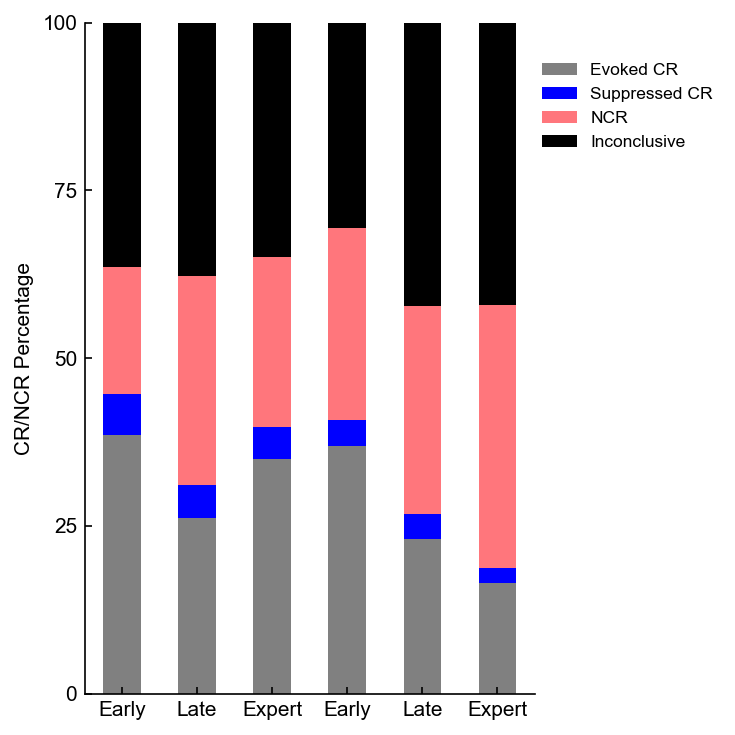

In [41]:
# size=5

# fig,ax = plt.subplots(figsize=(5,5))

# cells = ['Evoked CR', 'Suppressed CR', 'NCR', 'Inconclusive']

# data_learning_phase = ['Early','Late','Expert','Early','Late','Expert']

# Evoked_CR = np.array([data_preearly[0],data_prelate[0],data_preexpert[0],data_postearly[0],data_postlate[0],data_postexpert[0]])
# Sup_CR = np.array([data_preearly[1],data_prelate[1],data_preexpert[1],data_postearly[1],data_postlate[1],data_postexpert[1]])
# NCR = np.array([data_preearly[2],data_prelate[2],data_preexpert[2],data_postearly[2],data_postlate[2],data_postexpert[2]])
# Inconclusive = np.array([data_preearly[3],data_prelate[3],data_preexpert[3],data_postearly[3],data_postlate[3],data_postexpert[3]])


# #data
# ax.bar(range(len(data_learning_phase)),Evoked_CR,label = 'Evoked CR',width = 0.5, color=CR_COLOR)
# ax.bar(range(len(data_learning_phase)),Sup_CR, bottom = Evoked_CR, label = 'Suppressed CR',width = 0.5,  color='b')
# ax.bar(range(len(data_learning_phase)),NCR,bottom = Evoked_CR + Sup_CR, label = 'NCR',width = 0.5,  color=NCR_COLOR)
# ax.bar(range(len(data_learning_phase)),Inconclusive,bottom = Evoked_CR+Sup_CR+NCR, label = 'Inconclusive',width = 0.5, color='black') 

# #Plot summary
# ax.set_ylim([0,1])
# ax.set_yticks([0,0.25,0.50,0.75,1])
# ax.set_yticklabels(['0','25','50','75','100'])
# ax.set_ylabel('CR/NCR Percentage')
# ax.legend(frameon=False,loc=(1,0.8))

# ax.set_xlim([-0.5,5.5])
# ax.set_xlim(ax.get_xlim())
# ax.set_xticks(range(len(data_learning_phase)))
# ax.set_xticklabels(data_learning_phase)

# plt.tight_layout()
# fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Figures','NCR_CR learning phase percentage ver1(95%).pdf'),transparent=False,facecolor="white")

In [128]:
#cell numbers
preearly_cell_num = len(cell_pval.prereversal_early)
prelate_cell_num =len(cell_pval.prereversal_late)
preexpert_cell_num = len(cell_pval.prereversal_expert)
postearly_cell_num = len(cell_pval.postreversal_early)
postlate_cell_num = len(cell_pval.postreversal_late)
postexpert_cell_num = len(cell_pval.postreversal_expert)

In [108]:
#Pie chart

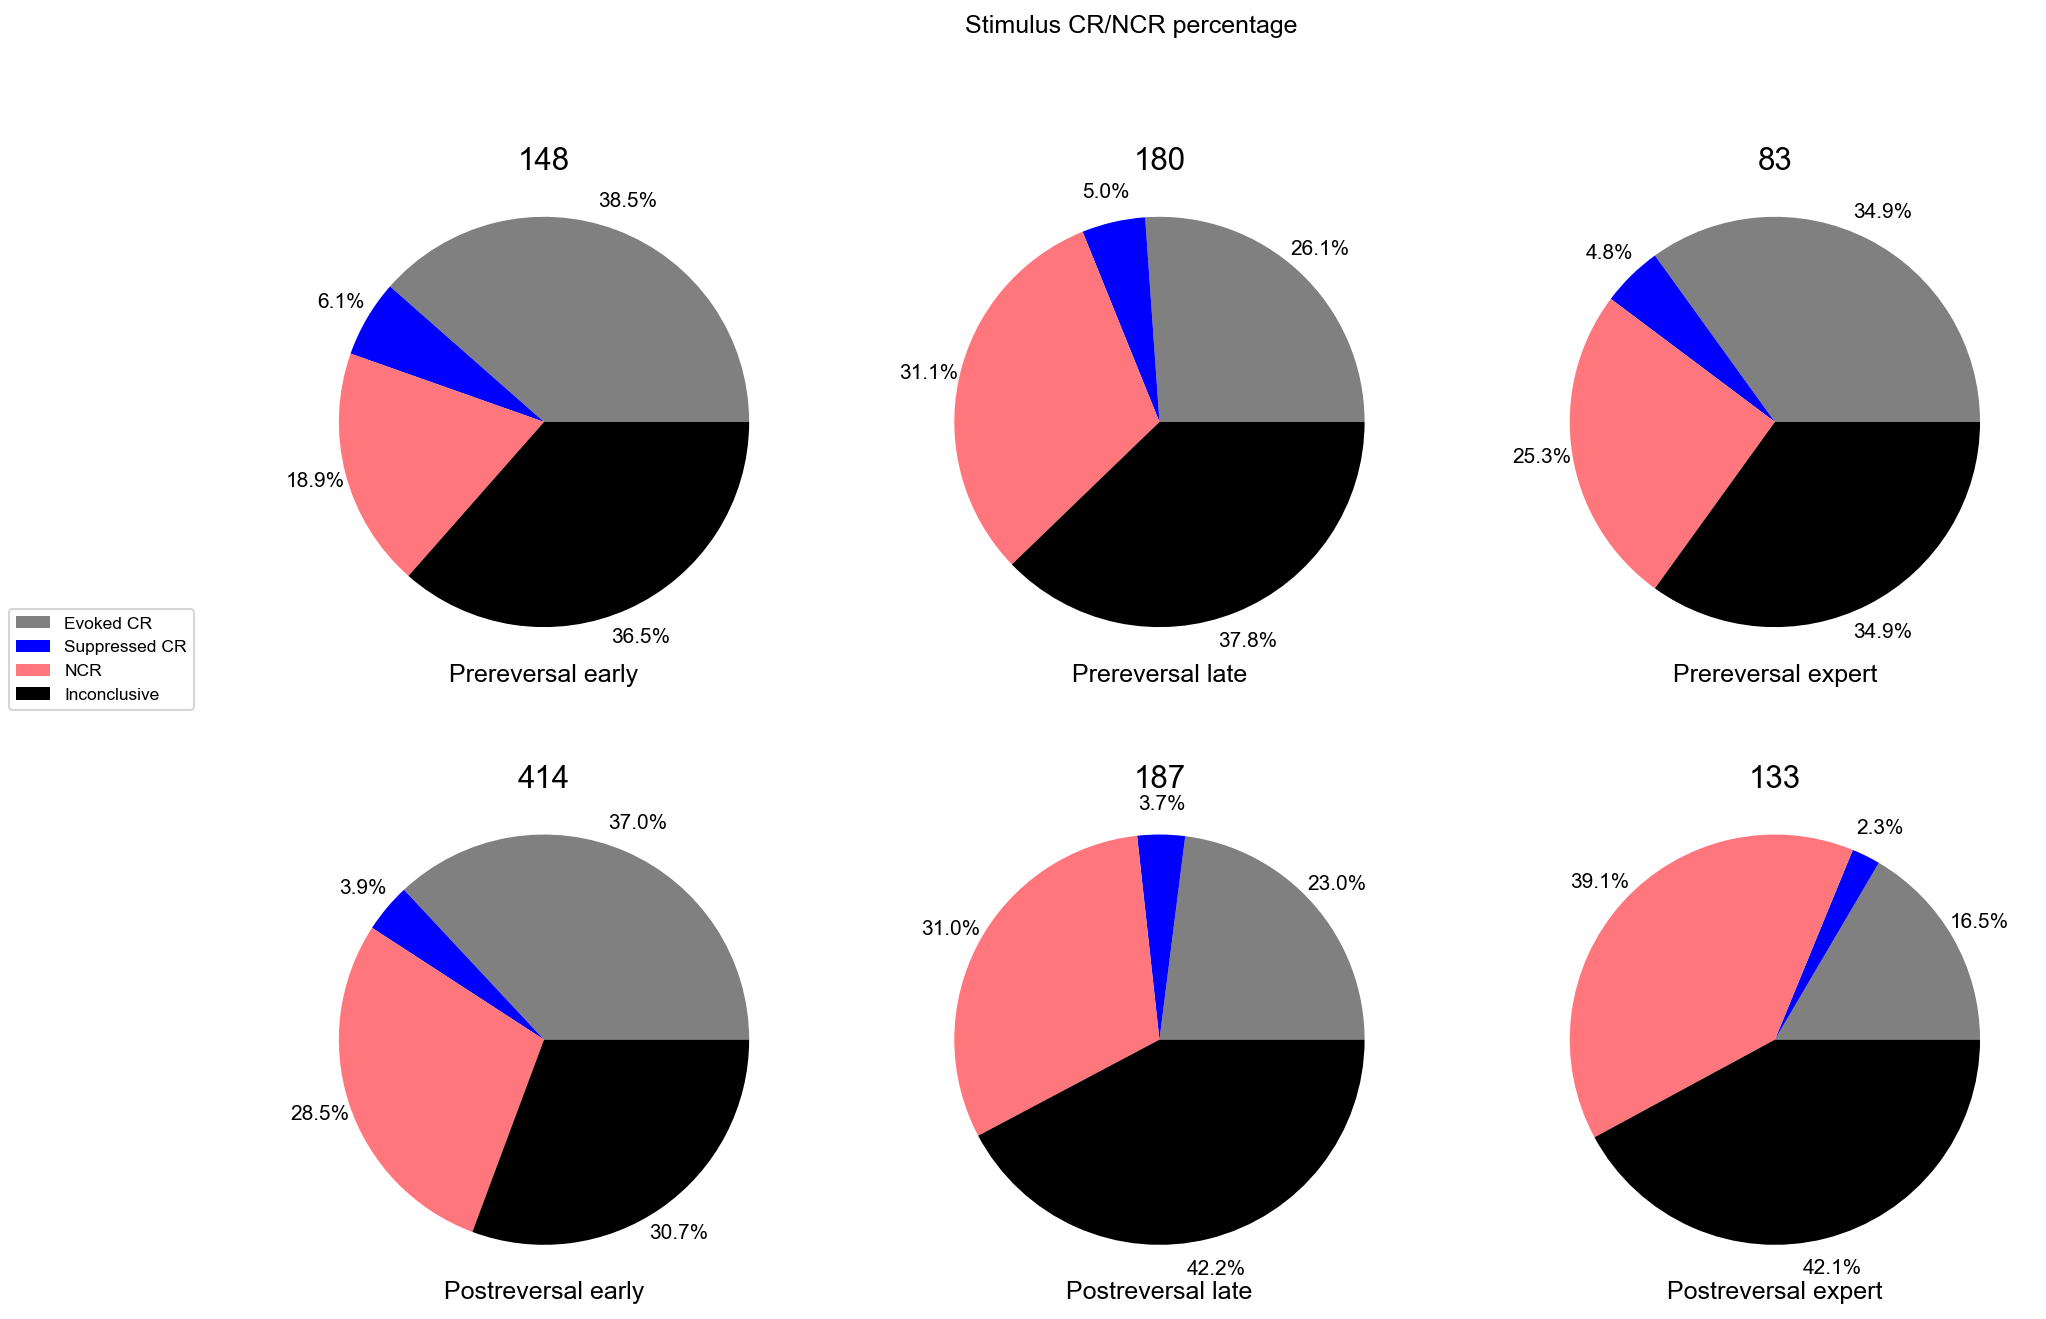

In [129]:
size=6

fig,ax = plt.subplots(2,3,figsize=(15,10))

cells = ['Evoked CR', 'Suppressed CR', 'NCR', 'Inconclusive']
prelearning_phase = ['Prereversal early','Prereversal late','Prereversal expert']
postlearning_phase = ['Postreversal early','Postreversal late','Postreversal expert']
colors = [CR_COLOR,'b',NCR_COLOR,'black']

#data
fig.suptitle('Stimulus CR/NCR percentage')
ax[0,0].pie(data_preearly, autopct='%1.1f%%',pctdistance=1.15, colors=colors)
ax[0,0].set_title('Prereversal early',y=-0.03)
ax[0,1].pie(data_prelate, autopct='%1.1f%%', pctdistance=1.15,colors=colors)
ax[0,1].set_title('Prereversal late',y=-0.03)
ax[0,2].pie(data_preexpert, autopct='%1.1f%%', pctdistance=1.15,colors=colors)
ax[0,2].set_title('Prereversal expert',y=-0.03)

ax[1,0].pie(data_postearly, autopct='%1.1f%%', pctdistance=1.15,colors=colors)
ax[1,0].set_title('Postreversal early',y=-0.03)
ax[1,1].pie(data_postlate, autopct='%1.1f%%', pctdistance=1.15,colors=colors)
ax[1,1].set_title('Postreversal late',y=-0.03)
ax[1,2].pie(data_postexpert, autopct='%1.1f%%', pctdistance=1.15,colors=colors)
ax[1,2].set_title('Postreversal expert',y=-0.03)

#num of cells
ax[0,0].text(0,1.2,str(preearly_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')
ax[0,1].text(0,1.2,str(prelate_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')
ax[0,2].text(0,1.2,str(preexpert_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')
ax[1,0].text(0,1.2,str(postearly_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')
ax[1,1].text(0,1.2,str(postlate_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')
ax[1,2].text(0,1.2,str(postexpert_cell_num),fontsize=15,horizontalalignment='center',verticalalignment='bottom')


#
fig.legend(labels=cells,
           loc="center left")
plt.show()
fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Figures','Stimulus NCR_CR learning phase percentage.pdf'),transparent=False,facecolor="white")

In [ ]:
raise NotImplementedError("BACK UP")